**Holt-Winters Exponential Smoothing univariate model for the prediction of meteorological time series data.**

# **LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Importa la clase ExponentialSmoothing para usar sus funciones básicas en el modelo de Holt-Winters.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score, mean_absolute_percentage_error
%matplotlib inline

# **DATA MANIPULATION**

In [ ]:
#--- LOAD DATA ---#
location = 'TIME-SERIES-Diario-13-23.csv'  ## DAILY DATA
# location = 'TIME-SERIES-Mensual-86-23.csv' ## MONTHLY DATA

series = pd.read_csv(location, delimiter=',')
series.head()

,Año,Mes,Dia,Fecha,Tｰ Media,TｰMaxima,TｰMinima,Lluvia,%Humedad
0,2013,Ene,1,1/1/2013,12.038,18.022,7.344,0.956,73.676
1,2013,Ene,2,1/2/2013,12.224,18.000,8.078,3.600,74.553
2,2013,Ene,3,1/3/2013,11.902,17.822,7.667,9.933,76.719
3,2013,Ene,4,1/4/2013,10.906,16.778,7.122,8.800,79.117
4,2013,Ene,5,1/5/2013,11.146,16.267,7.211,4.956,79.746


In [ ]:
# INDEX
# Set the 'Fecha' column as the DataFrame index.
series['Fecha'] = pd.to_datetime(series['Fecha'])
series.set_index('Fecha', inplace=True)

# Change header names
series = series.rename(columns={"Tｰ Media": "Temp_media", "TｰMaxima": "Temp_max", "TｰMinima": "Temp_min", "Lluvia": "Precipitacion", "%Humedad": "Humedad"})

In [ ]:
#--- SELECT TARGET VARIABLE ---#
# DROP COLUMNS THAT ARE NOT GOING TO BE USED
# We are dropping all columns except 'Temp_max' to isolate the target variable.
series = series.drop(["Año", "Dia", "Mes", "Temp_media", "Humedad", "Precipitacion", "Temp_min"], axis=1) # DAILY MAXIMUM TEMPERATURE DATA FRAME
# data = data.drop(["Año", "Mes", "Temp_media", "Humedad", "Temp_min", "Precipitacion"], axis=1)# # MONTHLY MAXIMUM TEMPERATURE DATA FRAME

series.head()

,Temp_max
Fecha,
2013-01-01,18.022
2013-01-02,18.000
2013-01-03,17.822
2013-01-04,16.778
2013-01-05,16.267


In [ ]:
#Check for null values
series.isnull().any()

,0
Temp_max,False


In [ ]:
# DROP NULL VALUES
series.dropna(inplace=True)

In [ ]:
# DATA SET INFORMATION
series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3883 entries, 2013-01-01 to 2023-08-19
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Temp_max  3883 non-null   float64
dtypes: float64(1)
memory usage: 60.7 KB


In [ ]:
# Basic descriptive stats
series.describe()

,Temp_max
count,3883.000000
mean,18.019176
std,2.143404
min,6.000000
25%,16.700000
50%,18.100000
75%,19.400000
max,24.900000


# **DATA PREPARATION**

## **DATA SPLIT**

In [ ]:
# SPLIT DATA (80%)
split_point = int(len(series) * 0.8)
train_data = series.iloc[:split_point]
test_data = series.iloc[split_point:]

In [ ]:
train_data.head(2)

,Temp_max
Fecha,
2013-01-01,18.022
2013-01-02,18.000


In [ ]:
test_data.head(2)

,Temp_max
Fecha,
2021-07-04,18.6
2021-07-05,18.8


# ***PARAMETERS OPTIMIZATION (OPTIONAL)***

In [ ]:
## Parámetros para la búsqueda de cuadrícula
# param_grid = {
#     'trend': ['add', 'mul'],
#     'seasonal': ['add', 'mul'],
#     'seasonal_periods': [30, 100, 200, 250, 270, 312, 325, 350, 365, 400]
# }

In [ ]:
# best_score = -float('inf')
# best_params = None

In [ ]:
# # Búsqueda de cuadrícula
# for params in ParameterGrid(param_grid):
#     model = ExponentialSmoothing(train_data['Temp_max'], **params).fit()
#     forecast = model.forecast(len(test_data))
#     score = r2_score(test_data, forecast)
#     if score > best_score:
#         best_score = score
#         best_params = params

In [ ]:
# Print the best parameters found
# print("Best Parameters:")
# print(best_params)

# **MODELS SETUP**

## **MULTIPLICATIVE**

***Multiplicative Model:***

A multiplicative model suggests that the components are multiplied together as follows:

`y(t) = Level * Trend * Seasonality * Noise`

A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time. A nonlinear trend is a curved line.
A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

In [ ]:
# USE EXPONENTIAL SMOOTHING MULTIPLICATIVE MODEL WITH PARAMETERS
train = train_data['Temp_max']
mult_model = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=365).fit()
#FORECAST MODEL
mult_forecast = mult_model.forecast(len(test_data)).rename('HW Forecast')
mult_forecast.head(4)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,HW Forecast
2021-07-04,17.368776
2021-07-05,17.152703
2021-07-06,16.181807
2021-07-07,17.841777


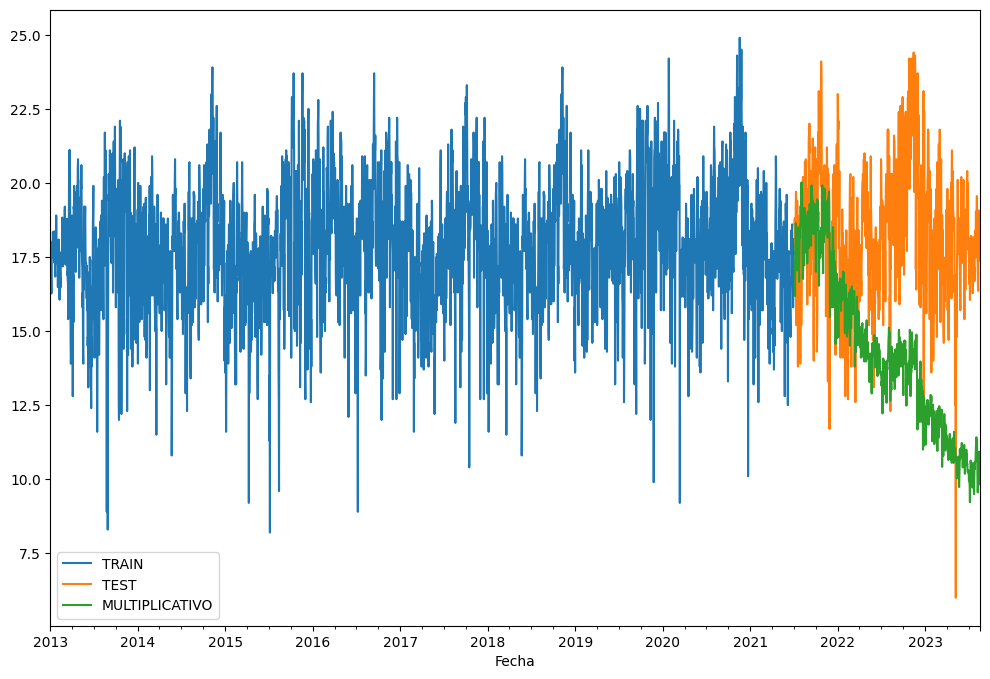

In [ ]:
# PLOT FORECASTING
train_data['Temp_max'].plot(legend=True, label='TRAIN')
test_data['Temp_max'].plot(legend=True, label='TEST', figsize=(12,8))
mult_forecast.plot(legend=True, label='MULTIPLICATIVO');

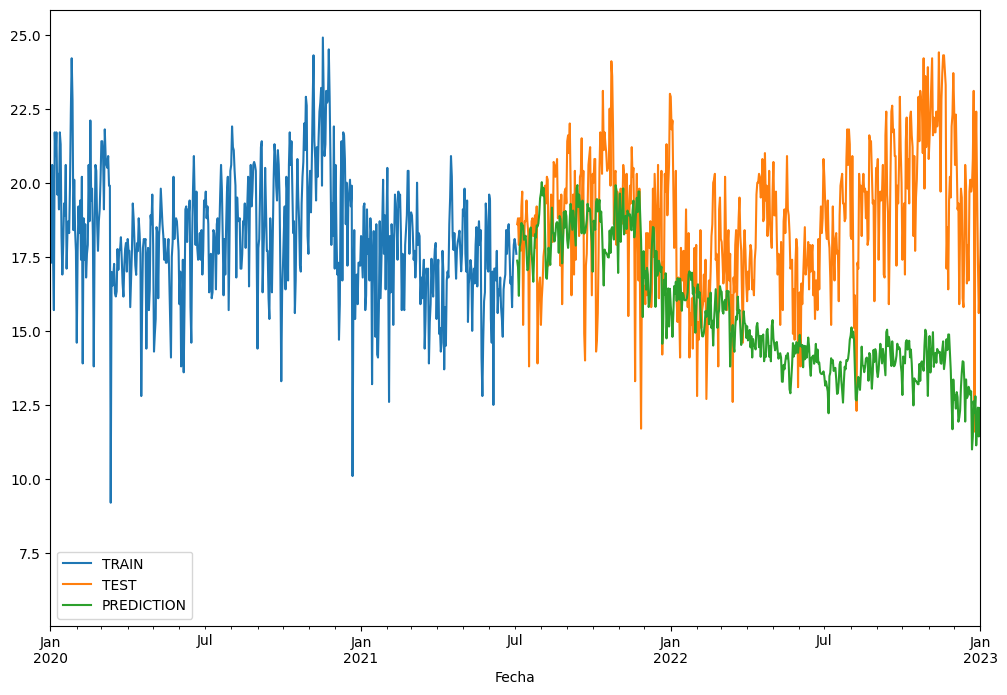

In [ ]:
# Zoom in to get a better view of forecast
train_data['Temp_max'].plot(legend=True, label='TRAIN')
test_data['Temp_max'].plot(legend=True, label='TEST', figsize=(12,8))
mult_forecast.plot(legend=True, label='PREDICTION', xlim=['2020-01-01','2023-01-01']);

In [ ]:
print(f"Length of test_data: {len(test_data)}")
print(f"Length of mult_forecast: {len(mult_forecast)}")

Length of test_data: 777
Length of mult_forecast: 777


In [ ]:
# Metric evaluation of multiplicative model
print('Multiplicative Model Evaluation')
# print(f"R-cuadrado: {r2_score(test_data,mult_forecast)}")
# print(f"MSE : {mean_squared_error(test_data,mult_forecast)}")
print(f"MAE : {mean_absolute_error(test_data,mult_forecast)}")
print(f"RMSE : {mean_squared_error(test_data,mult_forecast)**.5}")
print(f"MAPE : {mean_absolute_percentage_error(test_data, mult_forecast) * 100}%")

Multiplicative Model Evaluation
MAE : 4.589731196841237
RMSE : 5.3781162195254835
MAPE : 24.37235341933941%


## ADDITIVE

***Additive Model:***

An additive model suggests that the components are added together as follows:

`y(t) = Level + Trend + Seasonality + Noise`

An additive model is linear where changes over time are consistently made by the same amount. A linear trend is a straight line.
A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

In [ ]:
# USE EXPONENTIAL SMOOTHING ADDITIVE MODEL WITH PARAMETERS
train = train_data['Temp_max']
add_model = ExponentialSmoothing(train_data['Temp_max'],trend='add',seasonal='add',seasonal_periods=365).fit()
# FORECAST MODEL
add_forecast = add_model.forecast(len(test_data)).rename('HW ADD Model')
add_forecast.head(4)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,HW ADD Model
2021-07-04,17.288271
2021-07-05,17.536079
2021-07-06,16.516478
2021-07-07,18.273868


<Axes: xlabel='Fecha'>

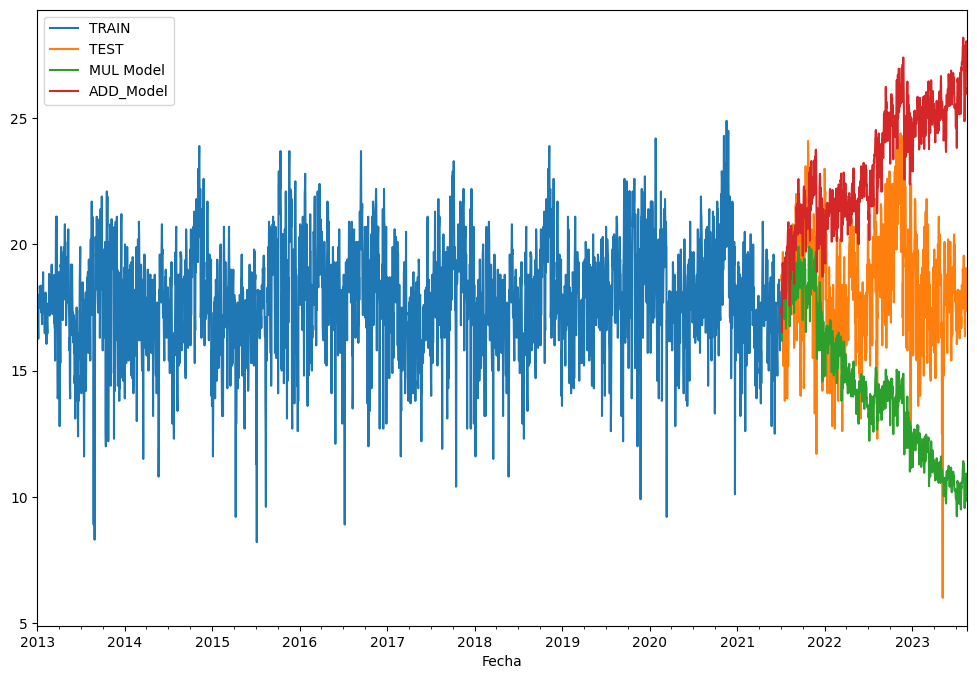

In [ ]:
# PLOT FORECASTING
train_data['Temp_max'].plot(legend=True, label='TRAIN')
test_data['Temp_max'].plot(legend=True, label='TEST', figsize=(12,8))
mult_forecast.plot(legend=True, label='MUL Model')
add_forecast.plot(legend=True, label='ADD_Model')

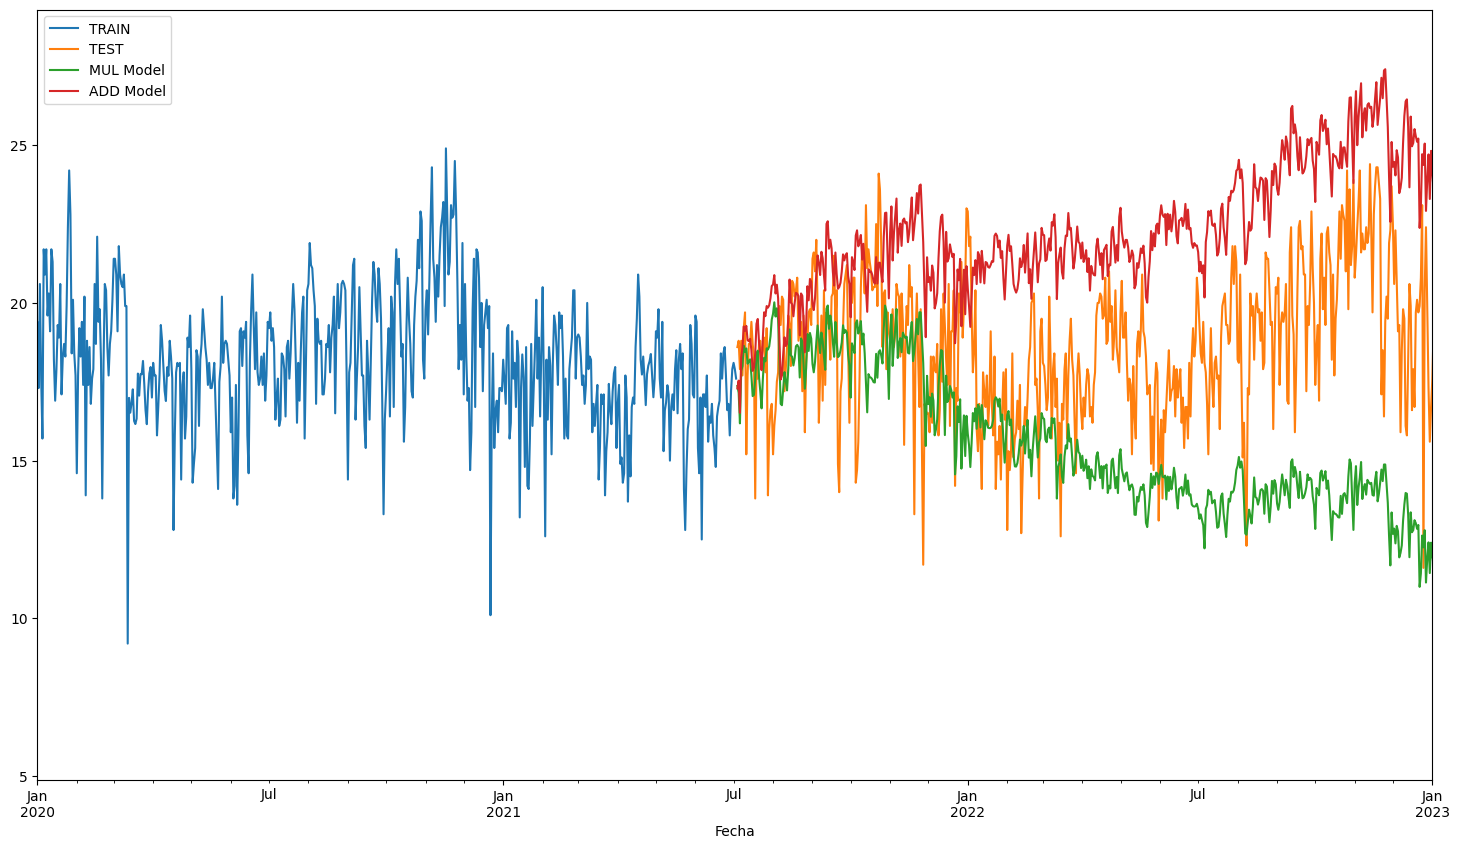

In [ ]:
# Zoom in to get a better view
train_data['Temp_max'].plot(legend=True, label='TRAIN')
test_data['Temp_max'].plot(legend=True,label='TEST', figsize=(18,10))
mult_forecast.plot(legend=True, label='MUL Model')
add_forecast.plot(legend=True, label='ADD Model', xlim=['2020-01-01','2023-01-01']);

In [ ]:
# Metric evaluation of additive model
print('Additive Model Evaluation')
# print(f"R-cuadrado : {r2_score(test_data,add_forecast)}")
# print(f"MSE : {mean_squared_error(test_data,add_forecast)}")
print(f"MAE : {mean_absolute_error(test_data,add_forecast)}")
print(f"RMSE : {mean_squared_error(test_data,add_forecast)**.5}")
print(f"MAPE : {mean_absolute_percentage_error(test_data, add_forecast) * 100}%")

Additive Model Evaluation
MAE : 4.866397340410181
RMSE : 5.62207190319134
MAPE : 28.177657872683344%


# **FUTURE FORECASTING**

In [ ]:
# MODEL USING EXPONENTIAL SMOOTHING
final_model = ExponentialSmoothing(series['Temp_max'],trend='add',seasonal='add',seasonal_periods=525).fit()

# Entrenamiento final con los mejores parámetros
# final_model = ExponentialSmoothing(train_data['Temp_max'], **best_params).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
# FORECAST FOR X DAYS
forecast_predictions = final_model.forecast(1080)

# Predicción con el modelo final
forecast_predictions = final_model.forecast(len(test_data)).rename('HW Forecast')

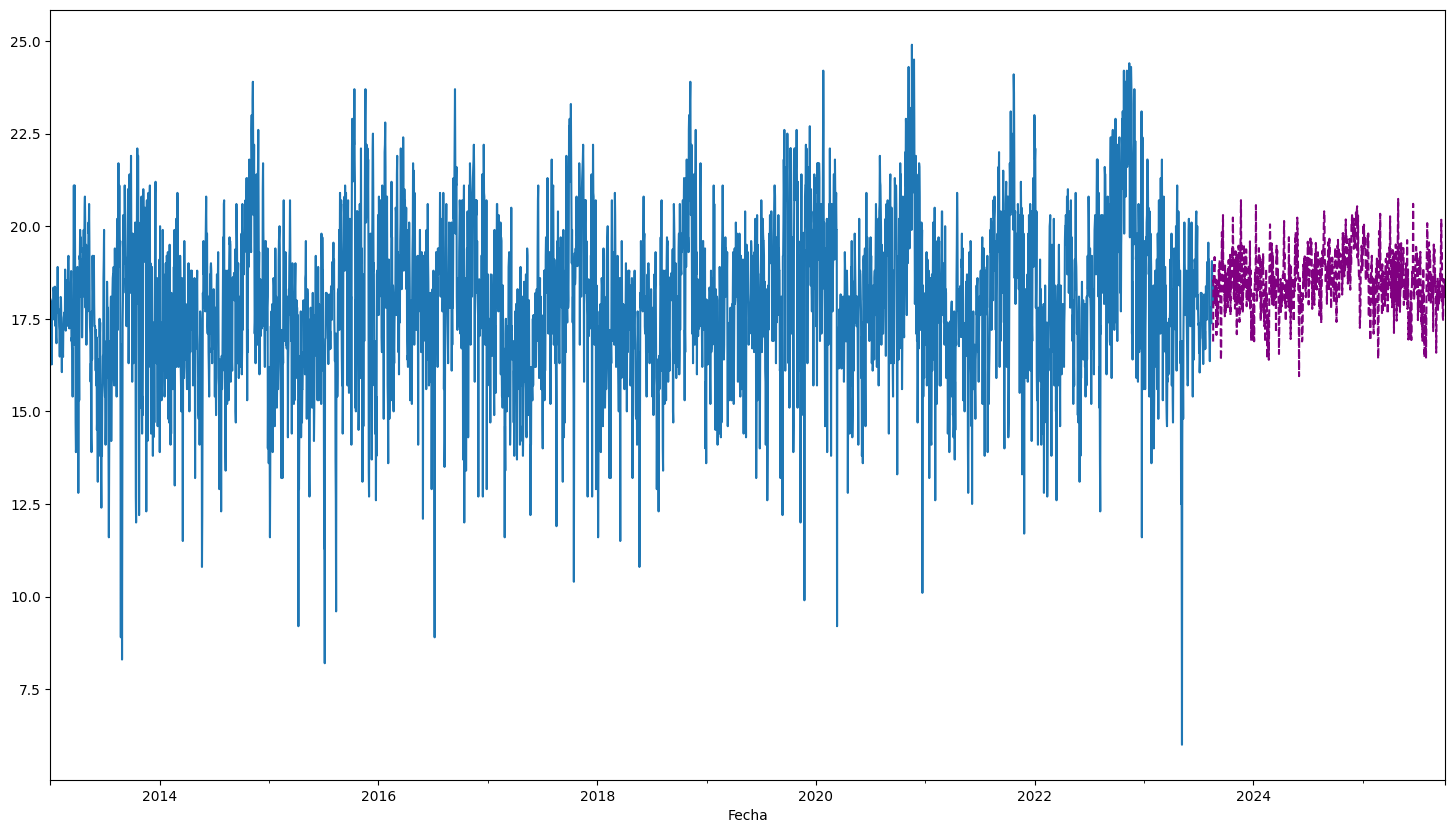

In [ ]:
# PLOT FUTURE FORECAST
series['Temp_max'].plot(figsize=(18,10))
forecast_predictions.plot(style='--', color='purple');
# fit1.forecast(12).plot(style='--', marker='o', color='green')

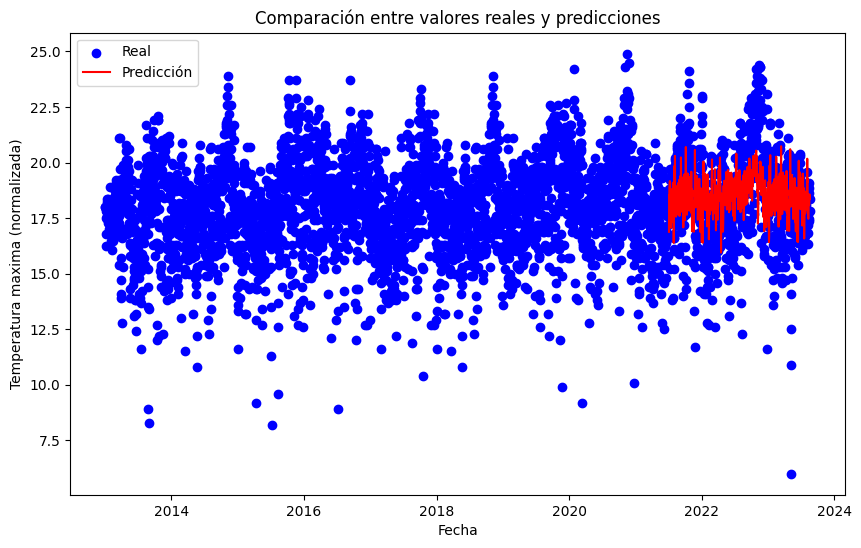

In [32]:
# Gráfico de dispersión de puntos entre los valores reales y las predicciones
plt.figure(figsize=(10, 6))
plt.scatter(series.index, series['Temp_max'], color='blue', label='Real')
plt.plot(test_data.index, forecast_predictions, color='red', label='Predicción')
plt.xlabel('Fecha')
plt.ylabel('Temperatura maxima (normalizada)')
plt.title('Comparación entre valores reales y predicciones')
plt.legend()
plt.show()

In [33]:
# FORECAST FOR X DAYS
forecast_predictions = final_model.forecast(3000)

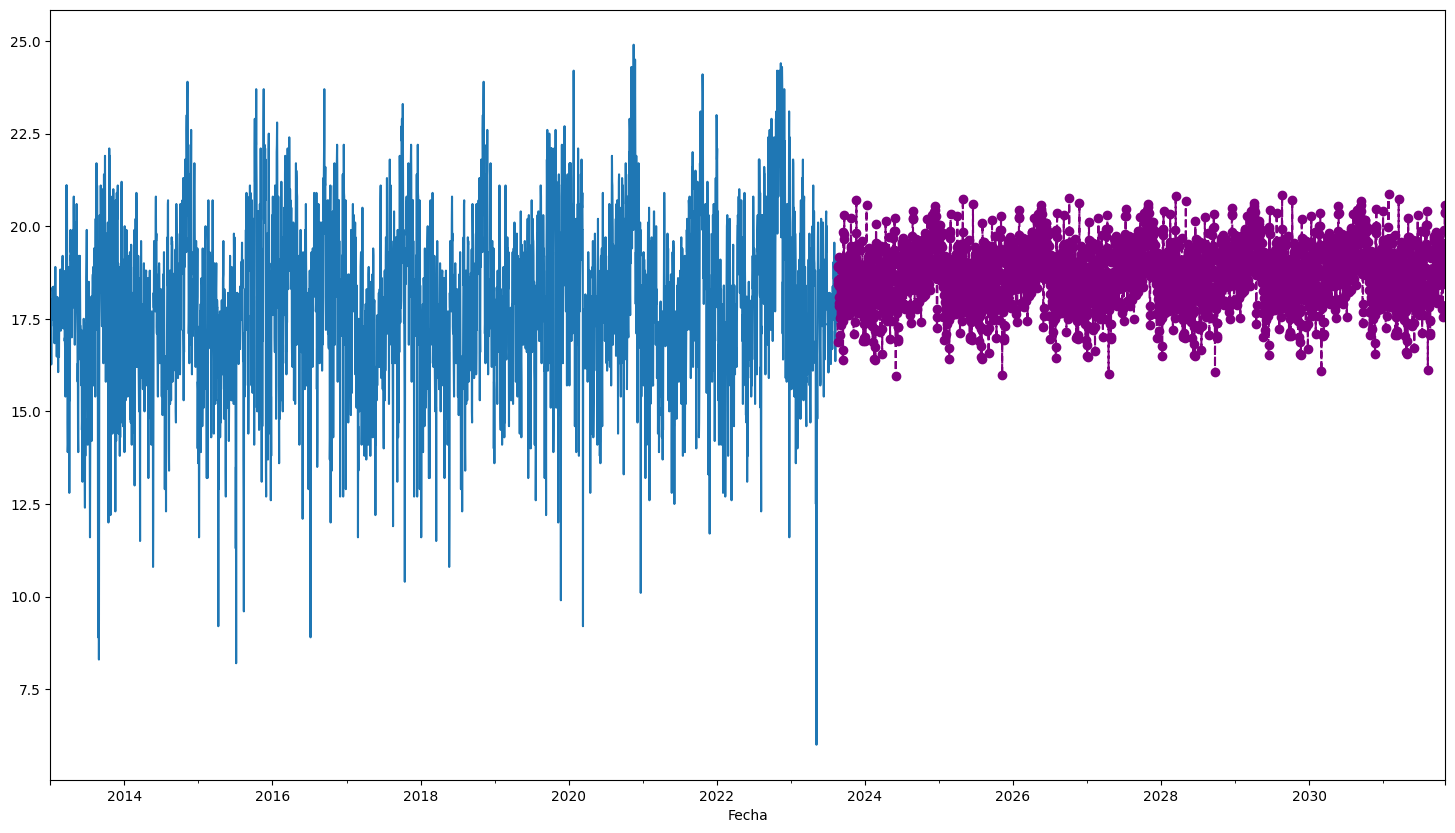

In [34]:
# PLOT FUTURE FORECAST
series['Temp_max'].plot(figsize=(18,10))
forecast_predictions.plot(style='--', marker='o', color='purple');
# fit1.forecast(12).plot(style='--', marker='o', color='green')